# Книжка направлена на валидацию полученной сети

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
import matplotlib.patches as patches


from nets_algo import *

# Загрузка тестовой выборки

In [2]:
X_test = np.load("training_valid_data/X_test.npy")
y_test = np.load("training_valid_data/y_test.npy")

X_test_tens = torch.tensor(X_test.astype('float32'))
y_test_tens = torch.tensor(y_test.astype('float32'))

# Функции для работы с валидацей моделей

## ROC кривая и AUC

In [8]:
def plot_roc(fpr, tpr):
    plt.figure(figsize = [10,10])
    plt.fill_between(
        fpr, tpr, hatch = '\\\\',
        alpha = 0
    )
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], '--')
    plt.margins(x = 0 , y = 0)
    plt.legend(
        [
            "AUC = " + str(np.round(auc(fpr, tpr), 3)),
            "ROC модели", 
             "ROC случаного классификатора"
        ],
        fontsize = 15
    )
    plt.xlabel("$FPR$", loc = "right", fontsize = 12)
    plt.ylabel("$TPR$", loc = "top", fontsize = 12)

## KS и оптимальная точка отсечения

In [12]:
def plot_KS(
    p, Nc_distr, Pc_distr, ax,
    N_plot_param = {},
    P_plot_param = {},
    x_lab_param = {}, 
    label_param = {}
):
    '''Нанесение KS на график'''
    ax.plot(p, Nc_distr, **N_plot_param)
    ax.plot(p, Pc_distr, **P_plot_param)
    
    plt.xlabel("$PD$", **x_lab_param)
    
    pKS = np.argmax(np.abs(Nc_distr - Pc_distr))
    
    KS_arrow = patches.FancyArrowPatch(
        (p[pKS], Nc_distr[pKS]), (p[pKS], Pc_distr[pKS]), 
        arrowstyle='<->', mutation_scale=20
    )
    
    ax.text(
        p[pKS], (Nc_distr[pKS] + Pc_distr[pKS]) / 2, "KS",
        **label_param
    )
    plt.margins(x = 0 , y = 0)
    
    # откакладываем и подписываем предсказания
    plt.text(p[pKS], 0.02, str(np.round(p[pKS],3)), fontsize = 14)
    plt.plot([p[pKS]]*2, [Nc_distr[pKS], 0], '--', color = 'black')
    plt.text(0.002, Nc_distr[pKS] + 0.01, str(np.round(Nc_distr[pKS], 3)))
    plt.plot([0,p[pKS]], [Nc_distr[pKS]]*2, '--', color = 'black')
    plt.text(0.002, Pc_distr[pKS] + 0.01, str(np.round(Pc_distr[pKS], 3)))
    plt.plot([0,p[pKS]], [Pc_distr[pKS]]*2, '--', color = 'black')
    
    ax.add_patch(KS_arrow)
    
    plt.legend([
        'Доля ошибочно предсказанных дефолтов',
        'Доля правильно предсказанных дефолтов'
    ], fontsize = 14)

# Модель 1 скрытый слой 113 нейронов

In [10]:
model = ResultNet([113, 113])
model.load_state_dict(torch.load('model 1lay 113 neurons'))

<All keys matched successfully>

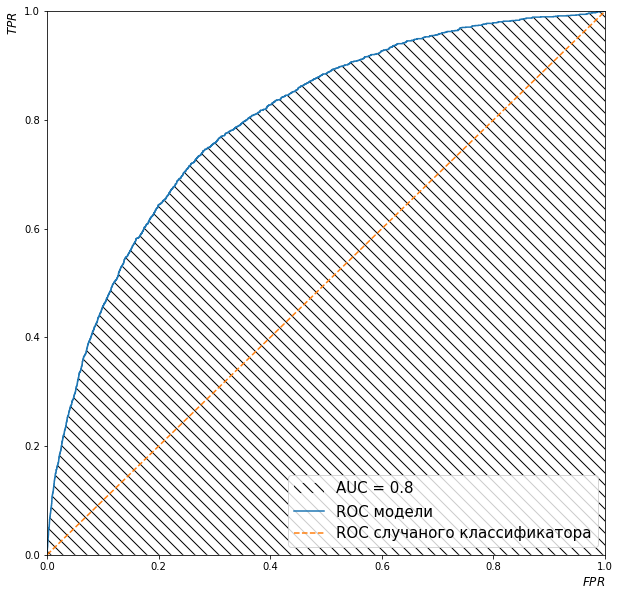

In [11]:
p_hat = model(X_test_tens).detach().numpy()
fpr, tpr, threholds = roc_curve(y_test, p_hat)
fpr = fpr[1:]
tpr = tpr[1:]
threholds = threholds[1:]

plot_roc(fpr, tpr)
plt.savefig("validation_results/1lay_133_roc.png")

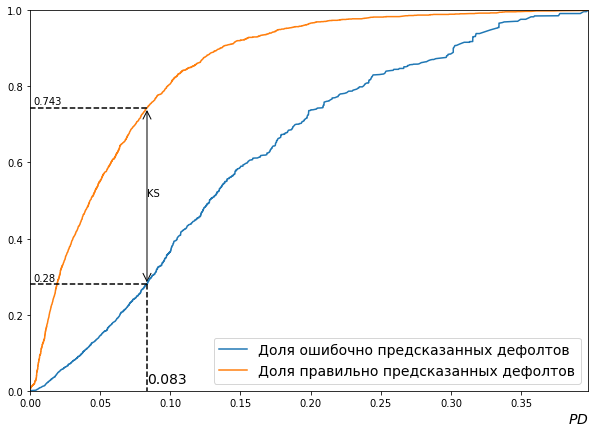

In [13]:
plt.figure(figsize = [10,7])

sel_cond = threholds < 0.4

plot_KS(
    np.sort(threholds[sel_cond]), 
    fpr[sel_cond], 
    tpr[sel_cond], 
    plt.subplot(111),
    x_lab_param = {
        'loc':'right',
        'fontsize':14
    }
)

plt.savefig("validation_results/1lay_113_KS_plot.png")